In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from rtdl_revisiting_models import FTTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
import optuna

# 환경 설정 및 경로 관리
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed_everything(SEED)

# M1 Pro 가속 및 경로 설정
DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
DATA_PATH = "../../data/raw/"
SUB_PATH = "./submissions/"

In [2]:

def preprocess_pipeline(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    
    # 타겟 매핑
    train['voted'] = train['voted'].replace({2: 1, 1: 0})
    
    # 범주형 변수 정의 (임베딩 대상)
    cat_cols = ['race', 'religion', 'urban', 'education', 'hand', 'married', 'engnat', 'gender']
    
    def engineering(df):
        # Q_A 역채점 및 마키아벨리즘 점수
        qa_cols = [f'Q{i}A' for i in 'abcdefghijklmnopqrst']
        df['mach_score'] = df[qa_cols].mean(axis=1)

        # Q_E 및 가족수 이상치 처리 (로그 변환)
        qe_cols = [f'Q{i}E' for i in 'abcdefghijklmnopqrst']
        for col in qe_cols:
            df[col] = np.log1p(df[col].clip(upper=df[col].quantile(0.99)))
        df['familysize'] = df['familysize'].clip(upper=df['familysize'].quantile(0.99))
            
        # tp/wr/wf 파생변수 생성
        df['tp_Extraversion'] = (df['tp01'] + (7 - df['tp06'])) / 2
        df['tp_Agreeableness'] = ((7 - df['tp02']) + df['tp07']) / 2
        df['tp_Conscientiousness'] = (df['tp03'] + (7 - df['tp08'])) / 2
        df['tp_EmotionalStability'] = ((7 - df['tp04']) + df['tp09']) / 2
        df['tp_Openness'] = (df['tp05'] + (7 - df['tp10'])) / 2
        
        df['wr_total'] = df[[f'wr_{i:02d}' for i in range(1, 14)]].sum(axis=1)
        df['wf_total'] = df[[f'wf_{i:02d}' for i in range(1, 4)]].sum(axis=1)
        
        # 연령대 수치화
        df['age_encoded'] = df['age_group'].str.extract('(\d+)').astype(float).fillna(60).replace(0, 60)
        return df

    train = engineering(train)
    test = engineering(test)

    # Label Encoding (FT-Transformer 임베딩용)
    # 0부터 시작하는 정수로 변환하며, Test에만 있는 값은 미연에 방지
    for col in cat_cols:
        le = LabelEncoder()
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        le.fit(pd.concat([train[col], test[col]]))
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        
    # 데이터 분리: 수치형(num) vs 범주형(cat)
    # 기존에 드랍하던 리스트 수정
    drop_list = [f'tp{i:02d}' for i in range(1, 11)] + \
                [f'wr_{i:02d}' for i in range(1, 14)] + [f'wf_{i:02d}' for i in range(1, 4)] + \
                ['age_group', 'index']
    
    # 수치형 피처 리스트 (범주형 컬럼을 제외한 모든 컬럼)
    X_all = train.drop(columns=['voted'] + drop_list, errors='ignore')
    num_cols = [c for c in X_all.columns if c not in cat_cols]
    
    # 카테고리 개수 저장 (모델 입력용)
    cardinalities = [train[col].nunique() for col in cat_cols]
    
    return train, test, num_cols, cat_cols, cardinalities

# 데이터 로드
train_df, test_df, num_cols, cat_cols, cardinalities = preprocess_pipeline(
    DATA_PATH + 'train.csv', DATA_PATH + 'test_x.csv'
)

# 스케일링 (수치형 데이터에만 적용)
scaler = StandardScaler()
train_num = scaler.fit_transform(train_df[num_cols])
test_num = scaler.transform(test_df[num_cols])

# 범주형 데이터는 그대로 numpy 변환
train_cat = train_df[cat_cols].values
test_cat = test_df[cat_cols].values
train_y = train_df['voted'].values

In [13]:
# --- Optuna 목적 함수 (Hyperparameter Tuning) ---
def objective(trial):
    # 탐색할 파라미터 제안
    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [256, 512, 1024])
    n_blocks = trial.suggest_int("n_blocks", 2, 4)
    d_token = trial.suggest_categorical("d_token", [64, 128])
    attention_dropout = trial.suggest_float("attention_dropout", 0.1, 0.3)
    ffn_dropout = trial.suggest_float("ffn_dropout", 0.1, 0.3)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_auc = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_num, train_y)):
        # 데이터 분리 및 텐서 변환
        x_num_train = torch.tensor(train_num[train_idx], dtype=torch.float32)
        x_cat_train = torch.tensor(train_cat[train_idx], dtype=torch.long)
        y_train = torch.tensor(train_y[train_idx], dtype=torch.float32).view(-1, 1)

        x_num_val = torch.tensor(train_num[val_idx], dtype=torch.float32).to(DEVICE)
        x_cat_val = torch.tensor(train_cat[val_idx], dtype=torch.long).to(DEVICE)
        y_val = train_y[val_idx]

        train_loader = DataLoader(
            TensorDataset(x_num_train, x_cat_train, y_train), 
            batch_size=batch_size, shuffle=True
        )

        # 모델 선언 (rtdl 라이브러리 활용)
        model = FTTransformer(
            n_cont_features=train_num.shape[1],
            cat_cardinalities=cardinalities,
            d_out=1,
            _is_default=False,             # 최신 규격 반영
            n_blocks=n_blocks,
            d_block=d_token,
            attention_n_heads=8,
            ffn_d_hidden_multiplier=4/3,
            attention_dropout=attention_dropout,
            ffn_dropout=ffn_dropout,
            residual_dropout=0.0,
        ).to(DEVICE)

        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.BCEWithLogitsLoss()

        # 학습 루프 (FT-Transformer는 수렴이 빠르므로 20 epoch 설정)
        for epoch in range(20):
            model.train()
            for b_num, b_cat, b_y in train_loader:
                b_num, b_cat, b_y = b_num.to(DEVICE), b_cat.to(DEVICE), b_y.to(DEVICE)
                optimizer.zero_grad()
                loss = criterion(model(b_num, b_cat), b_y)
                loss.backward()
                optimizer.step()

        # 평가
        model.eval()
        with torch.no_grad():
            logits = model(x_num_val, x_cat_val).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            cv_auc.append(roc_auc_score(y_val, probs))
            
    return np.mean(cv_auc)

In [16]:
# --- 3. 실행 및 시각화 ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)


[I 2026-01-29 11:47:45,226] A new study created in memory with name: no-name-de3e5d29-fe2f-4ed0-9e59-caeaa5e389c6
[I 2026-01-29 12:08:12,080] Trial 0 finished with value: 0.7678961753505487 and parameters: {'lr': 0.0001971405965821575, 'batch_size': 512, 'n_blocks': 3, 'd_token': 128, 'attention_dropout': 0.18173545309073974, 'ffn_dropout': 0.18548758097462842}. Best is trial 0 with value: 0.7678961753505487.
[I 2026-01-29 12:18:40,327] Trial 1 finished with value: 0.7673917557099659 and parameters: {'lr': 0.00014012695338539927, 'batch_size': 256, 'n_blocks': 2, 'd_token': 64, 'attention_dropout': 0.2131423819645426, 'ffn_dropout': 0.11357433506493458}. Best is trial 0 with value: 0.7678961753505487.
[I 2026-01-29 12:28:41,323] Trial 2 finished with value: 0.7666749997006534 and parameters: {'lr': 0.00015957560834102978, 'batch_size': 512, 'n_blocks': 2, 'd_token': 64, 'attention_dropout': 0.14248394450108035, 'ffn_dropout': 0.1404385274841997}. Best is trial 0 with value: 0.767896175


Best Validation AUC: 0.7689


/var/folders/q4/yj_kszs56h10dm1b5l1cmby00000gn/T/ipykernel_4798/3842003292.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


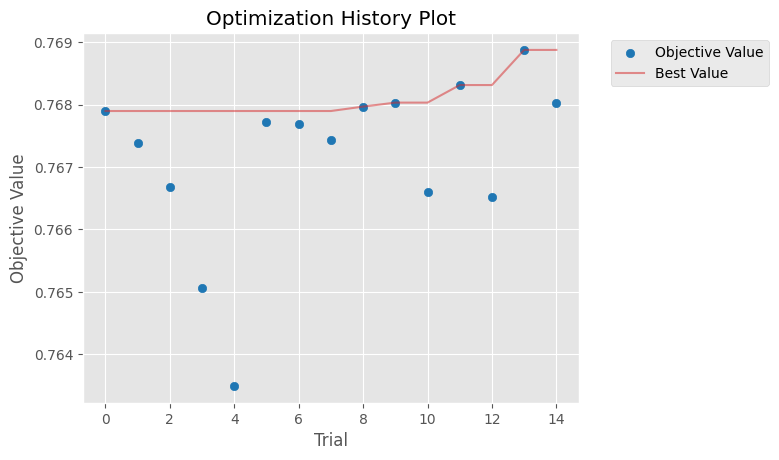

In [17]:
print(f"\nBest Validation AUC: {study.best_value:.4f}")
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [18]:
# --- 최종 재학습 (8:2 분할 모니터링) ---
best_p = study.best_params
X_n_tr, X_n_val, X_c_tr, X_c_val, y_tr, y_val = train_test_split(
    train_num, train_cat, train_y, test_size=0.2, random_state=SEED, stratify=train_y
)

In [19]:
# 텐서 및 로더
final_train_loader = DataLoader(
    TensorDataset(torch.tensor(X_n_tr, dtype=torch.float32), 
                  torch.tensor(X_c_tr, dtype=torch.long), 
                  torch.tensor(y_tr, dtype=torch.float32).view(-1, 1)),
    batch_size=best_p['batch_size'], shuffle=True
)

X_n_val_t, X_c_val_t = torch.tensor(X_n_val, dtype=torch.float32).to(DEVICE), torch.tensor(X_c_val, dtype=torch.long).to(DEVICE)

final_model = FTTransformer(
    n_cont_features=train_num.shape[1],
    cat_cardinalities=cardinalities,
    d_out=1,
    _is_default=False,
    n_blocks=best_p['n_blocks'],
    d_block=best_p['d_token'],
    attention_n_heads=8,
    ffn_d_hidden_multiplier=4/3,
    attention_dropout=best_p['attention_dropout'],
    ffn_dropout=best_p['ffn_dropout'],
    residual_dropout=0.0,
).to(DEVICE)

optimizer = optim.AdamW(final_model.parameters(), lr=best_p['lr'], weight_decay=1e-2)
criterion = nn.BCEWithLogitsLoss()

# 히스토리 추적
history = {'loss': [], 'val_auc': []}
FINAL_EPOCHS = 25

pbar = tqdm(range(FINAL_EPOCHS), desc="Final Training")
for epoch in pbar:
    final_model.train()
    e_loss = 0
    for b_n, b_c, b_y in final_train_loader:
        b_n, b_c, b_y = b_n.to(DEVICE), b_c.to(DEVICE), b_y.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(final_model(b_n, b_c), b_y)
        loss.backward()
        optimizer.step()
        e_loss += loss.item()
    
    # 매 에포크 검증
    final_model.eval()
    with torch.no_grad():
        v_probs = torch.sigmoid(final_model(X_n_val_t, X_c_val_t).squeeze()).cpu().numpy()
        v_auc = roc_auc_score(y_val, v_probs)
    
    history['loss'].append(e_loss/len(final_train_loader))
    history['val_auc'].append(v_auc)
    pbar.set_postfix({'AUC': f'{v_auc:.4f}'})

python(16658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Final Training:   0%|          | 0/25 [00:00<?, ?it/s]

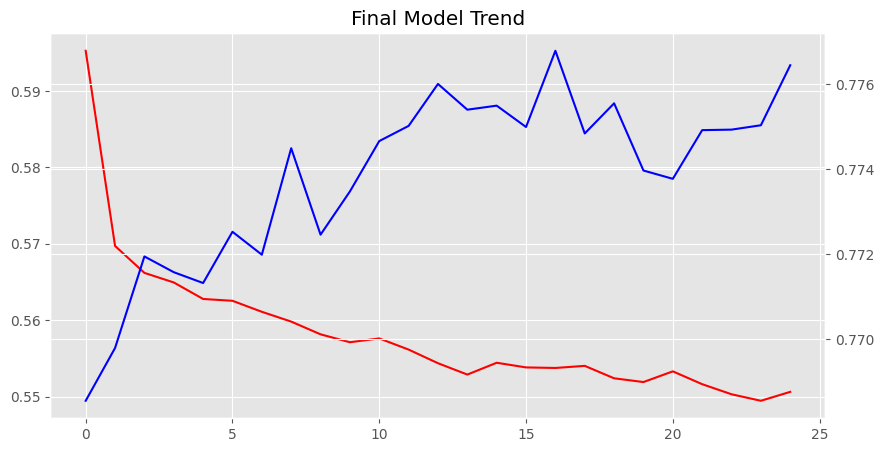

In [20]:
# 시각화
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(history['loss'], color='red', label='Loss')
ax2 = ax1.twinx()
ax2.plot(history['val_auc'], color='blue', label='AUC')
plt.title("Final Model Trend")
plt.show()

In [21]:
# --- 최종 예측 및 제출 ---
final_model.eval()
with torch.no_grad():
    test_n_t = torch.tensor(test_num, dtype=torch.float32).to(DEVICE)
    test_c_t = torch.tensor(test_cat, dtype=torch.long).to(DEVICE)
    final_probs = torch.sigmoid(final_model(test_n_t, test_c_t).squeeze()).cpu().numpy()

sample_sub = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
sample_sub["voted"] = final_probs
save_name = f"sub_FTTransformer_auc_{study.best_value:.4f}.csv"
sample_sub.to_csv(os.path.join(SUB_PATH, save_name), index=False)
print(f"Saved: {save_name}")

Saved: sub_FTTransformer_auc_0.7689.csv
